# Conversion

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

%matplotlib inline

# Grid
* NX=160, NY=269 (=43,040)
* 1grid =50m
* 8000m, 13450m
* 26246ft, 44127 ft

In [2]:
NX=160
NY=269
Xmeter=NX*50
Ymeter=NY*50
Xfeet=NX*50*3.28084
Yfeet=NY*50*3.28084
print (Xmeter, Ymeter, Xfeet, Yfeet)

8000 13450 26246.72 44127.298


# Soft dataの読み込み
* Trendソフトデータ (小松)
* Probソフトデータ (小松)
* 42,900 *6 Layer

In [3]:
ST=r'soft\Trend'
SP=r'soft\Prob'
def Read(fol, data, Layer, val):
    L=fol + r'\\' + data
    petrel = pd.read_csv(L, delim_whitespace=True, names=('xm', 'ym', val))
    petrel['Layer']=Layer

    return petrel

st1=Read(ST, 'D-1_Trend', 'D1', 'poro')
st2=Read(ST, 'D-2_Trend', 'D2', 'poro')
st3=Read(ST, 'D-3_Trend', 'D3', 'poro')
#st4=Read(ST, 'E-1_Trend', 'E1', 'poro')
#st5=Read(ST, 'E-2_Trend', 'E2', 'poro')
#st6=Read(ST, 'E-3_Trend', 'E3', 'poro')
st4=Read(ST, 'E-1', 'E1', 'poro')
st5=Read(ST, 'E-2', 'E2', 'poro')
st6=Read(ST, 'E-3', 'E3', 'poro')


soft_por=pd.concat([st1, st2, st3, st4, st5, st6]).reset_index(drop=True)

sp1=Read(SP, 'D-1_Prob', 'D1', 'ngr')
sp2=Read(SP, 'D-2_Prob', 'D2', 'ngr')
sp3=Read(SP, 'D-3_Prob', 'D3', 'ngr')
sp4=Read(SP, 'E-1_Prob', 'E1', 'ngr')
sp5=Read(SP, 'E-2_Prob', 'E2', 'ngr')
sp6=Read(SP, 'E-3_Prob', 'E3', 'ngr')

soft_ngr=pd.concat([sp1, sp2, sp3, sp4, sp5, sp6]).reset_index(drop=True)

soft=soft_por
soft=soft.assign(
        ngr= soft_ngr.ngr
    )

# gridのローテーション

* 35度回転したままではGSLBの計算は出来るが、かなり面倒な処理となる？
* ここでは35度逆回転させて、原点に戻している操作

In [4]:
XOFFSETf=34593.5206
YOFFSETf=119478.5687
XOFFSETm=XOFFSETf/3.28084
YOFFSETm=YOFFSETf/3.28084
theta=35

# soft data
soft=soft.assign(
    x0m=np.cos(-theta/360*2*np.pi)*(soft.xm-XOFFSETm)+np.sin(-theta/360*2*np.pi)*(soft.ym-YOFFSETm),
    y0m=-np.sin(-theta/360*2*np.pi)*(soft.xm-XOFFSETm)+np.cos(-theta/360*2*np.pi)*(soft.ym-YOFFSETm),
    x0f=(np.cos(-theta/360*2*np.pi)*(soft.xm-XOFFSETm)+np.sin(-theta/360*2*np.pi)*(soft.ym-YOFFSETm))*3.28084,
    y0f=(-np.sin(-theta/360*2*np.pi)*(soft.xm-XOFFSETm)+np.cos(-theta/360*2*np.pi)*(soft.ym-YOFFSETm))*3.28084
)

# Geo-EASデータ作成

In [5]:
# 出力フォルダ
FST=r'soft\TrendNew'
FSP=r'soft\ProbNew'
FST2=r'soft/TrendNew'
FSP2=r'soft/ProbNew'

def make_dat(folder, dat, DE, val):    
    s=soft[soft.Layer==DE]
    geos=s.assign(
        x1=s['x0f'].round(2),
        y1=s['y0f'].round(2),
        v1=s[val].round(5),   ################ poro or ngr  
    )[['x1', 'y1', 'v1']]

    
    pas=folder + r'\\' + dat                     #ファイルパス
    with open(pas, mode = 'w') as fh:           #書き込みモード
        fh.write('2D check\n')
        fh.write('3\n')
        fh.write('Xlocation\n')
        fh.write('Ylocation\n')
        fh.write('Primary\n')
        fh.close()
    
    out=geos[['x1', 'y1', 'v1']]
    out.to_csv(pas, index=False, sep='\t', mode='a', header=False)
    

# DE [D1, D2, D3, E1, E2, E3]
#poro
make_dat(FST, 'D1.dat', 'D1', 'poro')
make_dat(FST, 'D2.dat', 'D2', 'poro')
make_dat(FST, 'D3.dat', 'D3', 'poro')
make_dat(FST, 'E1.dat', 'E1', 'poro')
make_dat(FST, 'E2.dat', 'E2', 'poro')
make_dat(FST, 'E3.dat', 'E3', 'poro')

#ngr
make_dat(FSP, 'D1.dat', 'D1', 'ngr')
make_dat(FSP, 'D2.dat', 'D2', 'ngr')
make_dat(FSP, 'D3.dat', 'D3', 'ngr')
make_dat(FSP, 'E1.dat', 'E1', 'ngr')
make_dat(FSP, 'E2.dat', 'E2', 'ngr')
make_dat(FSP, 'E3.dat', 'E3', 'ngr')

# .Parデータ作成 

In [6]:
def make_par(folder, folder2, dat, out, par, radi, cc, a_h):
    newout= folder + r'\\' + par
    fi = open('kb2d.par', 'r')
    fo = open(newout, 'w')
    line = fi.readline() # 1行を文字列として読み込む(改行文字も含まれる)

    L04= folder2 + r'/' + dat +'\n'                              #-  file with data
    L09= folder2 + r'/' + out +'\n'                              #-  file for simulation output
    L14= np.str(radi) + '\n'                                    # -  maximum search radius
    L17 ='1   ' + np.str(cc) + '  0.0  '+ np.str(a_h)+'  '+ np.str(a_h) +'\n' # -it, c, azm, a_max, a_min

    for i in range(37):
        if(i==4):
            fo.writelines(L04)
        elif(i==9):
            fo.writelines(L09)
        elif(i==14):
            fo.writelines(L14)            
        elif(i==17):
            fo.writelines(L17)    
        else: 
            fo.writelines(line)
        
        line = fi.readline()

    fo.close()
    fi.close()
    
#make_par(フォルダ, dat, out, par, radii, cc, a_h)
#poro

make_par(FST, FST2, 'D1.dat', 'D1.out', 'D1.par', 50000.0, 1.0, 50000.0)
make_par(FST, FST2, 'D2.dat', 'D2.out', 'D2.par', 50000.0, 1.0, 50000.0)
make_par(FST, FST2, 'D3.dat', 'D3.out', 'D3.par', 50000.0, 1.0, 50000.0)
make_par(FST, FST2, 'E1.dat', 'E1.out', 'E1.par', 50000.0, 1.0, 50000.0)
make_par(FST, FST2, 'E2.dat', 'E2.out', 'E2.par', 50000.0, 1.0, 50000.0)
make_par(FST, FST2, 'E3.dat', 'E3.out', 'E3.par', 50000.0, 1.0, 50000.0)

#poro
make_par(FSP, FSP2, 'D1.dat', 'D1.out', 'D1.par', 50000.0, 1.0, 50000.0)
make_par(FSP, FSP2, 'D2.dat', 'D2.out', 'D2.par', 50000.0, 1.0, 50000.0)
make_par(FSP, FSP2, 'D3.dat', 'D3.out', 'D3.par', 50000.0, 1.0, 50000.0)
make_par(FSP, FSP2, 'E1.dat', 'E1.out', 'E1.par', 50000.0, 1.0, 50000.0)
make_par(FSP, FSP2, 'E2.dat', 'E2.out', 'E2.par', 50000.0, 1.0, 50000.0)
make_par(FSP, FSP2, 'E3.dat', 'E3.out', 'E3.par', 50000.0, 1.0, 50000.0)

# 実行run Trend

In [7]:
for parname in list(['D1.par', 'D2.par', 'D3.par', 'E1.par', 'E2.par', 'E3.par']):
    runpass = 'kb2d.exe ' + FST + r'\\' + parname
    os.system(runpass)

# 実行run Prob

In [8]:
for parname in list(['D1.par', 'D2.par', 'D3.par', 'E1.par', 'E2.par', 'E3.par']):
    runpass = 'kb2d.exe ' + FSP + r'\\' + parname
    os.system(runpass)

# Rotation soft data

In [9]:
def make_soft(f1, f2, parout, layer):
    fin1  = f1 + r'\\' + parout
    check1 = pd.read_csv(fin1, delim_whitespace=True, names=['poro', 'variance'])
    check1 = check1.iloc[4:,0:1].reset_index( drop = True ).astype(float)

    fin2  = f2 + r'\\' + parout
    check2 = pd.read_csv(fin2, delim_whitespace=True, names=['ngr', 'variance'])
    check2 = check2.iloc[4:,0:1].reset_index( drop = True ).astype(float)
    
    check =pd.concat([check1, check2], axis=1)
    
    check['Layer']=layer
    check['x0f'] = (25 + 50*(check.index % NX))*3.28084
    check['y0f'] = (25 + 50*(check.index // NX))*3.28084 
    
    return check

L1=make_soft(FST, FSP, 'D1.out', 'D1')
L2=make_soft(FST, FSP, 'D2.out', 'D2')
L3=make_soft(FST, FSP, 'D3.out', 'D3')
L5=make_soft(FST, FSP, 'E1.out', 'E1')
L6=make_soft(FST, FSP, 'E2.out', 'E2')
L7=make_soft(FST, FSP, 'E3.out', 'E3')

rotsoft=pd.concat([L1, L2, L3, L5, L6, L7])
rotsoft.head(3)

,poro,ngr,Layer,x0f,y0f
0,14.011311,0.423581,D1,82.021,82.021
1,14.001747,0.422271,D1,246.063,82.021
2,13.989188,0.420547,D1,410.105,82.021


# Soft data の図
* 42,900 point

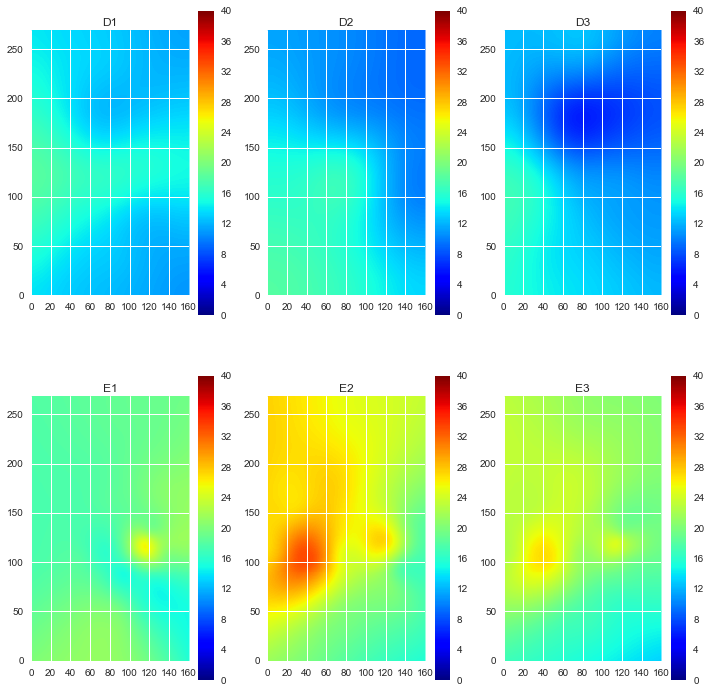

In [10]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], ['D1', 'D2', 'D3', 'E1', 'E2', 'E3']):
    plt.subplot(n)
    graph=rotsoft[rotsoft.Layer==g].poro.reshape(NY,NX)

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 40)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

# ヒストグラムの確認 Trend

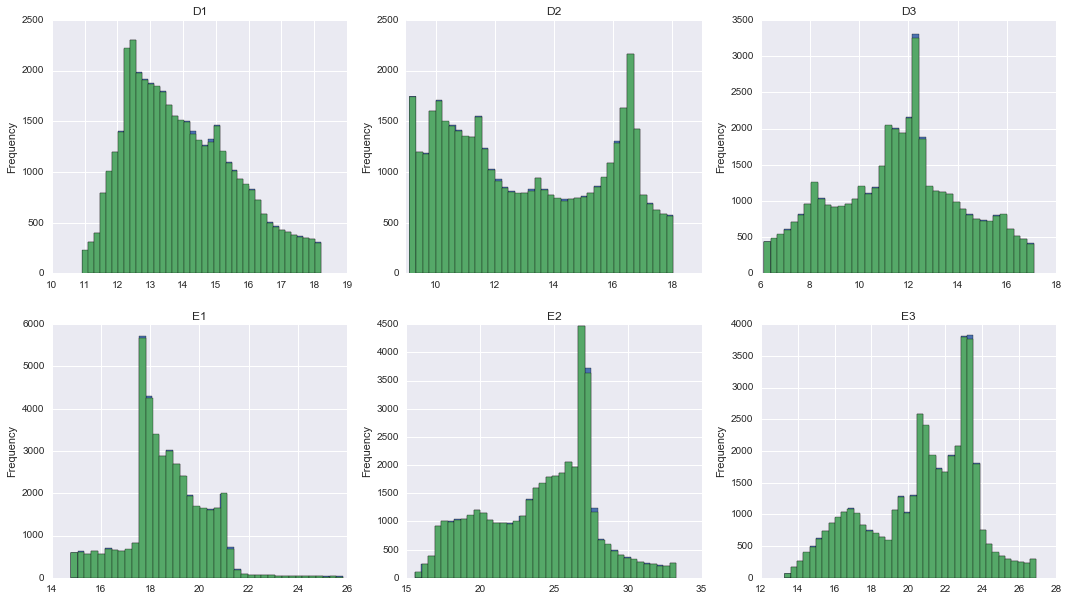

In [11]:
plt.figure(figsize=(18,10))
for n, g in zip([231, 232, 233, 234, 235, 236], ['D1', 'D2', 'D3', 'E1', 'E2', 'E3']):
    plt.subplot(n)

    rotsoft[rotsoft.Layer==g].poro.plot.hist(bins=40)   
    soft[(soft.Layer==g)].poro.plot.hist(bins=40)
    
    plt.title(g)    

# ヒストグラムの確認 Prob

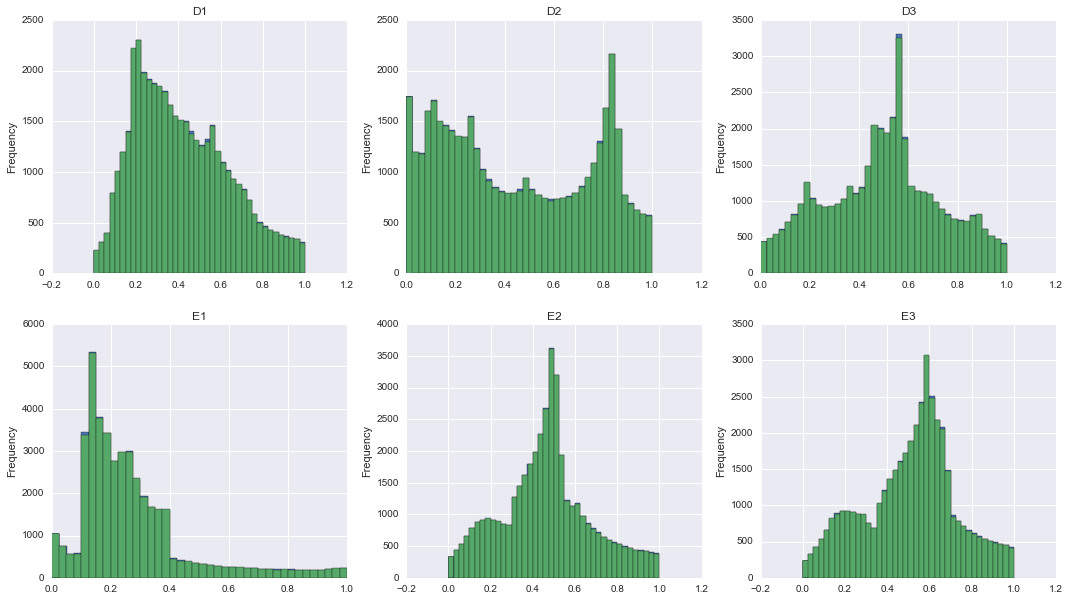

In [12]:
plt.figure(figsize=(18,10))
for n, g in zip([231, 232, 233, 234, 235, 236], ['D1', 'D2', 'D3', 'E1', 'E2', 'E3']):
    plt.subplot(n)

    rotsoft[rotsoft.Layer==g].ngr.plot.hist(bins=40)   
    soft[(soft.Layer==g)].ngr.plot.hist(bins=40)
    
    plt.title(g)    

# Depth & Thickness読み込み

In [13]:
f = open(r'model\GridPaydepth-ft.txt')
line = f.read()
f.close()
Paydepth=line.split()

f = open(r'model\GridThickness-ft.txt')
line = f.read()
f.close()
Thickness=line.split()


model=pd.DataFrame({
    'Depth': Paydepth,
    'Thickness': Thickness,
})

model=model.assign(
    K = (model.index //(NX*NY*4))+1,
    #pointall = model.index//4,
    point = (model.index//4) % (NX*NY),
    corner= model.index %4
)

# Grid Depth & Thickness

In [14]:
def DT(Layer):
    DTdata=pd.DataFrame({
        'D0': model.Depth[(model.K==Layer) & (model.corner==0)].reset_index(drop=True).astype(float),
        'D1': model.Depth[(model.K==Layer) & (model.corner==1)].reset_index(drop=True).astype(float),
        'D2': model.Depth[(model.K==Layer) & (model.corner==2)].reset_index(drop=True).astype(float),
        'D3': model.Depth[(model.K==Layer) & (model.corner==3)].reset_index(drop=True).astype(float),
        'T0': model.Thickness[(model.K==Layer) & (model.corner==0)].reset_index(drop=True).astype(float),
        'T1': model.Thickness[(model.K==Layer) & (model.corner==1)].reset_index(drop=True).astype(float),
        'T2': model.Thickness[(model.K==Layer) & (model.corner==2)].reset_index(drop=True).astype(float),
        'T3': model.Thickness[(model.K==Layer) & (model.corner==3)].reset_index(drop=True).astype(float)
        }
    )
    DTdata=DTdata.assign(
        #ave = dep.mean(axis=1)
        AveD = (DTdata.D0 + DTdata.D1 + DTdata.D2 + DTdata.D3)*0.25,
        AveT = (DTdata.T0 + DTdata.T1 + DTdata.T2 + DTdata.T3)*0.25,
        K = Layer,
        NUM= DTdata.index
    )
    return DTdata

DT_ALL=pd.concat([DT(1), DT(2), DT(3), DT(4), DT(5), DT(6), DT(7)])

In [15]:
zz=4
print('%.1f' % DT(zz).ix[84-1+(113-1)*NX].AveD)
print('%.1f' % DT(zz).ix[85-1+(175-1)*NX].AveD)
print('%.1f' % DT(zz).ix[118-1+(76-1)*NX].AveD)
print('%.1f' % DT(zz).ix[86-1+(233-1)*NX].AveD)
print('%.1f' % DT(zz).ix[41-1+(107-1)*NX].AveD)
print('%.1f' % DT(zz).ix[117-1+(119-1)*NX].AveD)
print('%.1f' % DT(zz).ix[82-1+(46-1)*NX].AveD)

8198.2
8708.1
8959.4
9111.5
8902.8
8967.4
9001.8


In [16]:
def make_soft_DE(Layer, L):
    aa=pd.DataFrame({
        'x0f': rotsoft.x0f[rotsoft.Layer=='D1'].round(2),
        'y0f': rotsoft.y0f[rotsoft.Layer=='D1'].round(2),
        'z': [L]*43040,
        'depth': DT_ALL.AveD[DT_ALL.K==L].round(2), 
        'poro': rotsoft.poro[rotsoft.Layer==Layer].round(5) if (L!=4) else 0.0,
        'ngr': rotsoft.ngr[rotsoft.Layer==Layer].round(5) if (L!=4) else 0.0,
        'thickness': DT_ALL.AveT[DT_ALL.K==L].round(5),
        'D4E': ['D']*43040 if (L<=3) else ['E']*43040 if (L>=5) else ['4']*43040,
        'GEOEASz': [L]*43040  if (L<=4) else [L-4]*43040   
        })[['x0f', 'y0f', 'z', 'depth', 'poro', 'ngr', 'thickness', 'D4E', 'GEOEASz']]
    
    return aa

DT1=make_soft_DE('D1',1)
DT2=make_soft_DE('D2',2)
DT3=make_soft_DE('D3',3)
DT4=make_soft_DE('4',4)
DT5=make_soft_DE('E1',5)
DT6=make_soft_DE('E2',6)
DT7=make_soft_DE('E3',7)

rotsoft_all=pd.concat([DT1, DT2, DT3, DT4, DT5, DT6, DT7]).reset_index(drop=True)
rotsoft_all.to_csv(r'soft\rotsoft_all.txt', index=False)
rotsoft_all.head(3)

,x0f,y0f,z,depth,poro,ngr,thickness,D4E,GEOEASz
0,82.02,82.02,1,9546.34,14.01131,0.42358,7.93848,D,1
1,246.06,82.02,1,9540.85,14.00175,0.42227,7.93261,D,1
2,410.10,82.02,1,9535.51,13.98919,0.42055,7.92700,D,1


# Depth

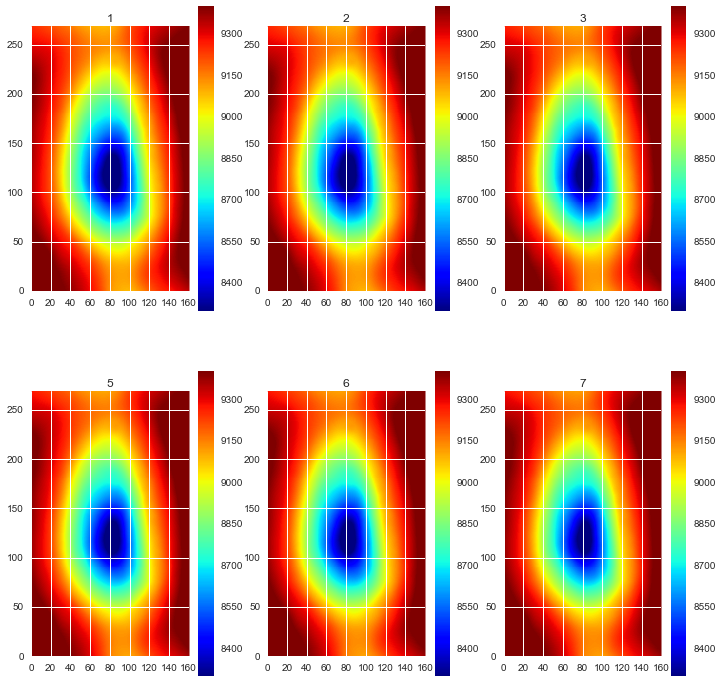

In [17]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], [1, 2, 3, 5, 6, 7]):
    plt.subplot(n)
    graph=rotsoft_all[rotsoft_all.z==g].depth.reshape(NY,NX)

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 8300.0, vmax = 9400)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

# Gross thickness

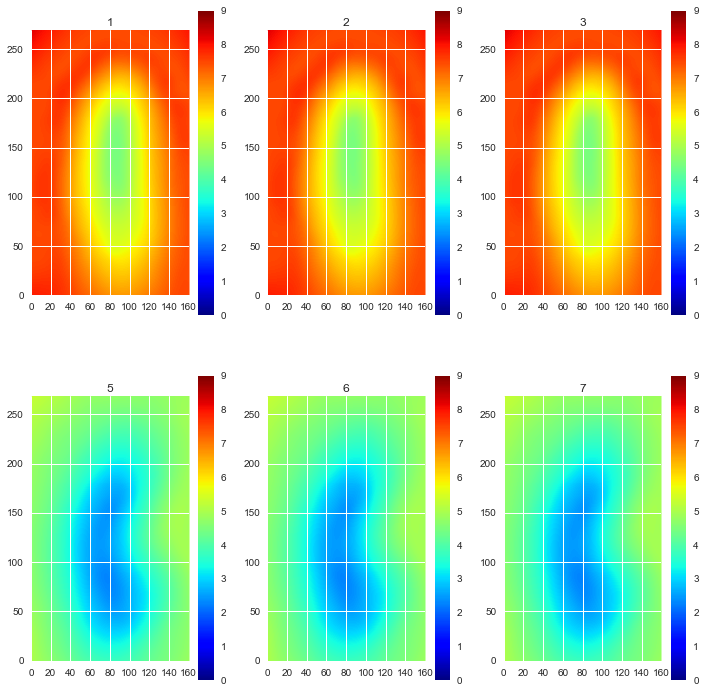

In [18]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], [1, 2, 3, 5, 6, 7]):
    plt.subplot(n)
    graph=rotsoft_all[rotsoft_all.z==g].thickness.reshape(NY,NX)

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 9)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

# Hard Data の読み込み
* Well Log porosity
* 7 Well
* 6 Lyayer (D1, D2, D3, E1, E2, E3)
* 7*6 pointがハードデータとなる
* soft\Prob\ngr.xlsx

In [19]:
hard_poro=pd.read_excel(r'hard\poro.xlsx', 'poro')
hard_ngr=pd.read_excel(r'hard\ngr.xlsx', 'ngr')

hard = hard_poro

hard=hard.assign(
    ngr= hard_ngr.ngr
)

hard=hard.assign(
    x0f=np.cos(-theta/360*2*np.pi)*(hard.x-XOFFSETf)+np.sin(-theta/360*2*np.pi)*(hard.y-YOFFSETf),
    y0f=-np.sin(-theta/360*2*np.pi)*(hard.x-XOFFSETf)+np.cos(-theta/360*2*np.pi)*(hard.y-YOFFSETf),
)

hard.poro =hard.poro.round(5)
hard.ngr =hard.ngr.round(5)
hard.x0f = hard.x0f.round(2)
hard.y0f = hard.y0f.round(2)
hard.x = hard.x.round(2)
hard.y = hard.y.round(2)

hard=hard.ix[:, ['x0f', 'y0f', 'z', 'depth', 'poro', 'ngr', 'x', 'y']]

hard['D4E']=hard.apply(lambda row: 'D' if (row.z<=3) else 'E' if (row.z>=5) else '4', axis=1)
hard['GEOEASz']=hard.apply(lambda row: row.z if (row.z<=4) else row.z-4, axis=1)

hard.to_csv(r'hard\hard_all.txt', index=False)
hard.head(3)

,x0f,y0f,z,depth,poro,ngr,x,y,D4E,GEOEASz
0,13746.34,18451.65,1,8182.5,16.05000,0.80000,56437.3,126708.7,D,1
1,13885.94,28589.54,1,8693.4,12.73333,0.60000,62366.5,134933.1,D,1
2,19337.57,12407.35,1,8941.4,12.50000,0.83333,57550.5,118550.5,D,1
